In [2]:
# calculate the area of the umbra in HRT (remapped) and HMI 

In [3]:
# now that HRT has straylight correction, the area is most likely larger that before...

In [25]:
import _pickle as cPickle
import json
import sunpy
import sunpy.map
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import os

font = {'family' : 'Open Sans',
        'weight' : 'normal',
        'size'   : 15}

import matplotlib as mpl
mpl.rc_file_defaults()
plt.rc('font', **font)
mpl.rcParams['image.origin'] = 'lower'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

#import sunpy.visualization.colormaps as cm
#magmap = mpl.colormaps['hmimag']

from datetime import datetime as dt
import matplotlib.dates as mdates
myFmt = mdates.DateFormatter('%d/%m %H:%M')

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [5]:
dates = [12,13,14,15,16,17]

num_files = int(len(os.listdir('/scratch/slam/sinjan/arlongterm_hmi/blos_45/')))

In [6]:
folder = '/data/slam/sinjan/arlongterm_pickles_hann_SL/'

In [7]:
def get_hrt_hmi_arr_from_pickles(folder, hrt_series, hmi_series, hrt_psf, hrt_suffix = '', hmi_suffix = '', year = '2023'):
    start = 0
    dates = [12,13,14,15,16,17]
    num_files = 129

    hrt_arr = np.zeros((4102,4102,num_files))
    hmi_arr = np.zeros((4102,4102,num_files))

    hrt_meta_list = []
    
    for i in dates:
        if i == 17:
            endhour = '11'
            endmin = '02'
            endday = 17
        else:
            endhour = '00'
            endmin = '00'
            endday = i+1
        with open(folder+f"HRTs_{hrt_series}_remapped_on_HMI_{year}10{i}T000000_{year}10{endday}T{endhour}{endmin}00{hrt_psf}.pickle{hrt_suffix}", "rb") as input_file:
            hrt_tmps = cPickle.load(input_file)
        
        with open(folder+f"HMIs_{hmi_series}_{year}10{i}T000000_{year}10{endday}T{endhour}{endmin}00.pickle{hmi_suffix}", "rb") as input_file:
            hmi_tmps = cPickle.load(input_file)
            
        for i,smap in enumerate(hrt_tmps):
            hrt_arr[:,:,start+i] = smap.data
            hrt_meta_list.append(smap.meta)
    
        for i,smap in enumerate(hmi_tmps): #could zip together the two for loops, but need iterable
            nans=np.isnan(hrt_arr[:,:,start+i])
            tmp = smap.data
            tmp[nans] = np.nan
            hmi_arr[:,:,start+i] = tmp
            
        start += len(hrt_tmps)

    return hrt_arr, hmi_arr, hrt_meta_list

In [9]:
#ic_45s with psf applied and straylight
folder = '/data/slam/sinjan/arlongterm_pickles_hann_SL/'
hrt_series = 'icnt'
hmi_series = 'ic_45s'
hrt_psf = '_hmipsf_True'
hrt_ic_arr,hmi_ic_arr,hrt_meta_list =  get_hrt_hmi_arr_from_pickles(folder, hrt_series, hmi_series, hrt_psf, hrt_suffix = '', hmi_suffix = '', year = '2023')

In [10]:
times = [dt.strptime(i['date-obs'][:-4],'%Y-%m-%dT%H:%M:%S') for i in hrt_meta_list]

In [11]:
hrt_umbra_idx=[]
hmi_umbra_idx=[]

for i in range(128):
    tmp = hmi_ic_arr[:,:,i]
    fac = np.mean(tmp[~np.isnan(tmp)])
    hmi_umbra=np.where(tmp/fac<=0.55)
    hrt_umbra=np.where(hrt_ic_arr[:,:,i]<=0.55)

    not_nans = np.where(~np.isnan(hrt_ic_arr[:,:,i]))
    bleft = (np.min(not_nans[1]),np.min(not_nans[0]))

    index_pairs = np.array(list(zip(hrt_umbra[0], hrt_umbra[1])))
    filtered_pairs = index_pairs[(index_pairs[:,0] >= bleft[1]+100) | (index_pairs[:,1] >= bleft[0]+100)]
    filtered_indices = (filtered_pairs[:,0],filtered_pairs[:,1])
    
    hrt_umbra_idx.append(filtered_indices)
    hmi_umbra_idx.append(hmi_umbra)

In [13]:
hmisize=2.42407e-6*1.496e8*1e5

In [14]:
hrt_size = [i[0].size*hmisize**2 for i in hrt_umbra_idx]
hmi_size = [i[0].size*hmisize**2 for i in hmi_umbra_idx]

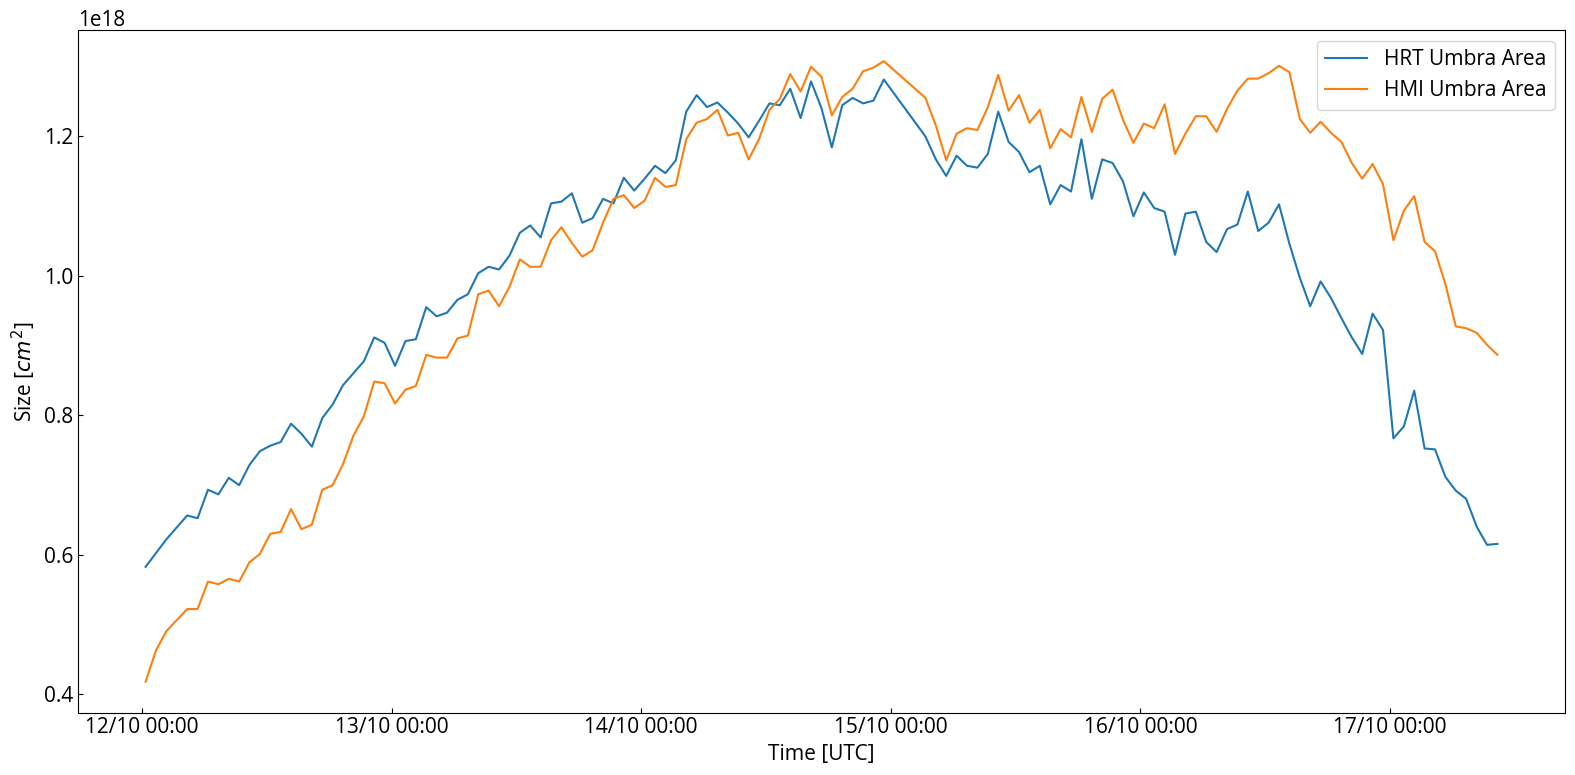

In [18]:
plt.figure(figsize=(16,8))
plt.plot(times,hrt_size,label='HRT Umbra Area')
plt.plot(times,hmi_size,label='HMI Umbra Area')
plt.xlabel('Time [UTC]')
plt.ylabel(r'Size [$cm^{2}$]')
ax=plt.gca()
ax.xaxis.set_major_formatter(myFmt)
plt.tight_layout()
plt.legend()

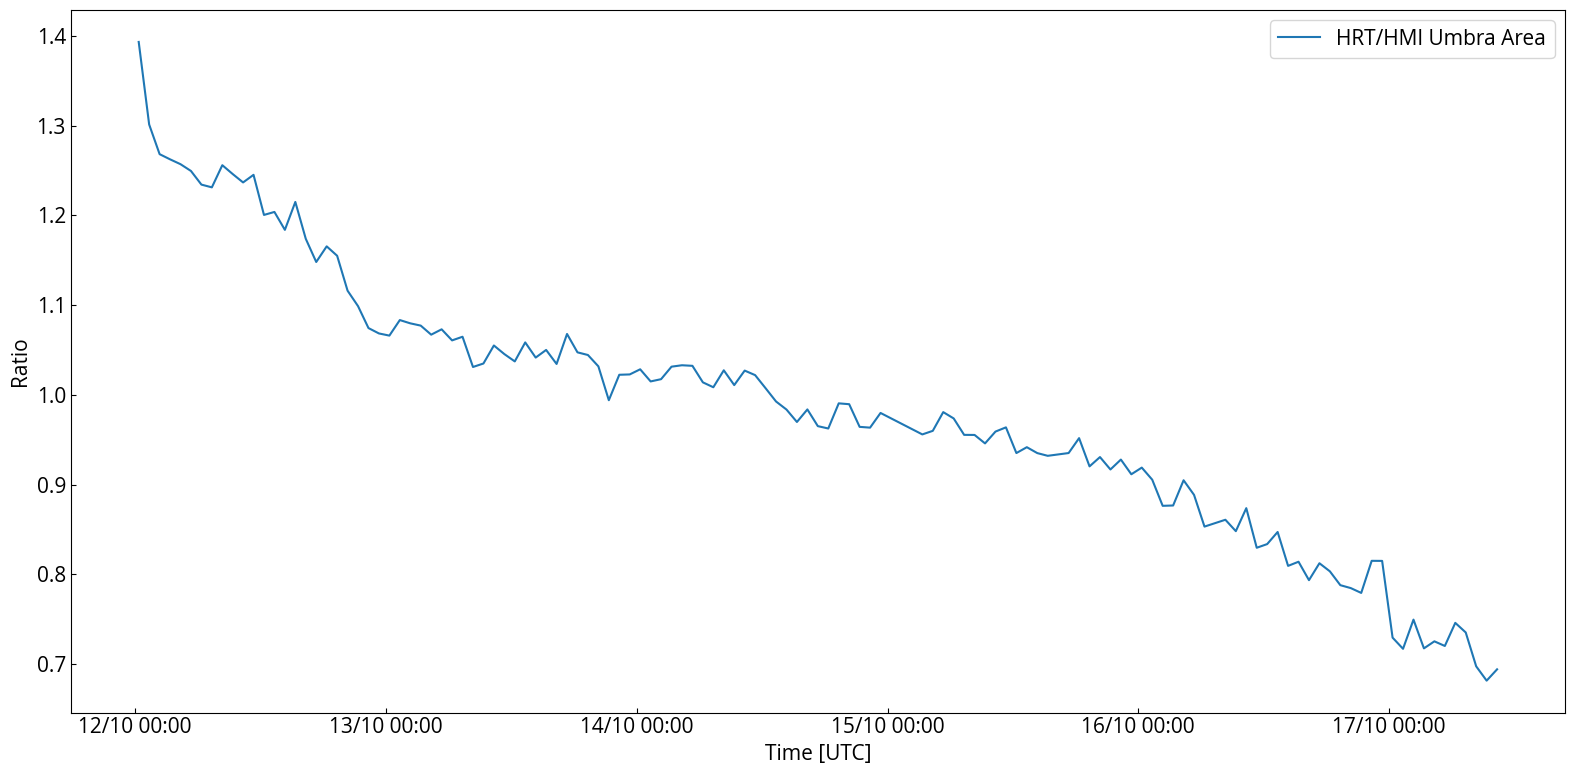

In [20]:
plt.figure(figsize=(16,8))
plt.plot(times,np.array(hrt_size)/np.array(hmi_size),label='HRT/HMI Umbra Area')
#plt.plot(times,hmi_size,label='HMI Umbra Area')
plt.xlabel('Time [UTC]')
plt.ylabel('Ratio')
ax=plt.gca()
ax.xaxis.set_major_formatter(myFmt)
plt.tight_layout()
plt.legend()

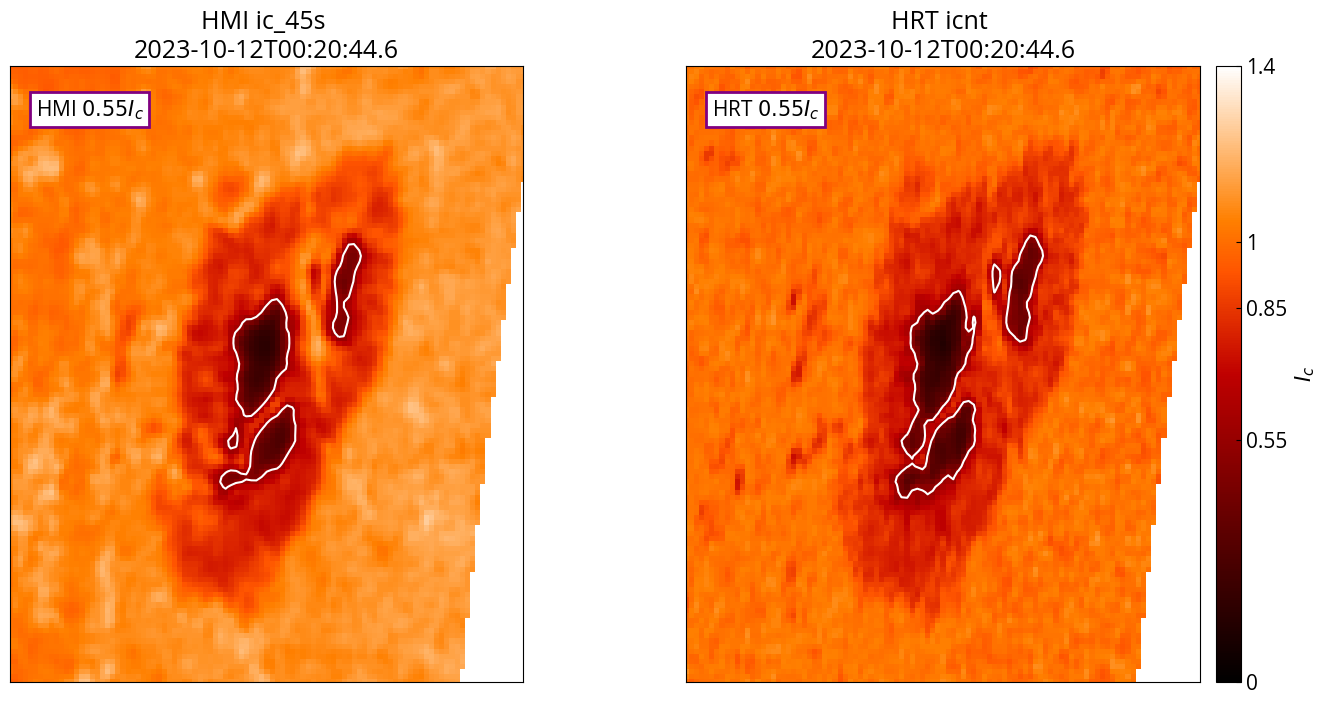

In [29]:
fig = plt.figure(figsize=(16,8))

cmax=1.4
cmin=0

i=0

tmp = hmi_ic_arr[:,:,i]
fac = np.mean(tmp[~np.isnan(tmp)])

ax = plt.subplot(121)
ax.set_aspect('equal')
ax.imshow(tmp/fac, origin = "lower", cmap = "gist_heat", vmin = cmin, vmax = cmax)
ax.set_title(f"HMI ic_45s \n2023-10-12T00:20:44.6") 

plt.xlim(250,350)
plt.ylim(2260,2380)

#contour of HRT FOV
x = range(tmp.shape[1])
y = range(tmp.shape[0])
xv, yv = np.meshgrid(x, y)
cs = plt.contour(xv, yv, tmp/fac, levels = [0.55],colors="white")
#plt.clabel(cs, inline=False)

#legend for contour
ylims = ax.get_ylim()
xlims = ax.get_xlim()
t = ax.text(0.05*(xlims[1]-xlims[0])+xlims[0],(0.92*(ylims[1]-ylims[0])+ylims[0])-0.1, s = r'HMI $0.55I_{c}$', fontsize=15)
t.set_bbox(dict(facecolor='white', alpha=1, edgecolor='purple', linewidth=2))

ax.xaxis.set_tick_params(labelbottom=False)
ax.yaxis.set_tick_params(labelleft=False)

# Hide X and Y axes tick marks
ax.set_xticks([])
ax.set_yticks([])

ax2 = plt.subplot(122)
ax2.set_aspect('equal')
hrt_data = hrt_ic_arr[:,:,i]
hrt_copy = ax2.imshow(hrt_data, origin = "lower", cmap = "gist_heat", vmin = cmin, vmax = cmax)
ax2.set_title(f'HRT icnt \n2023-10-12T00:20:44.6')

# plt.ylim(800,1400)
# plt.xlim(1150,1700)
plt.xlim(250,350)
plt.ylim(2260,2380)

#contour of HRT FOV
x = range(hrt_data.shape[1])
y = range(hrt_data.shape[0])
xv, yv = np.meshgrid(x, y)
cs = plt.contour(xv, yv, hrt_data, levels = [0.55],colors="white")
#plt.clabel(cs, inline=False)

#legend for contour
ylims = ax2.get_ylim()
xlims = ax2.get_xlim()
t = ax2.text(0.05*(xlims[1]-xlims[0])+xlims[0],(0.92*(ylims[1]-ylims[0])+ylims[0])-0.1, s = 'HRT $0.55I_{c}$', fontsize=15)
t.set_bbox(dict(facecolor='white', alpha=1, edgecolor='purple', linewidth=2))

ax2.xaxis.set_tick_params(labelbottom=False)
ax2.yaxis.set_tick_params(labelleft=False)

# Hide X and Y axes tick marks
ax2.set_xticks([])
ax2.set_yticks([])

axins4 = inset_axes(ax2,width="5%",height="100%",loc='center right',borderpad=-2)
cbar = fig.colorbar(hrt_copy, cax=axins4, orientation="vertical", ticks=[0,0.55,0.85,1,1.4])
cbar.ax.yaxis.set_ticks_position('right')
cbar.set_label(r"$I_{c}$")
cbar.ax.set_yticklabels(['0','0.55','0.85','1','1.4'])

#plt.savefig('../plots/original_blos_hrt_hmi_m45s_zoom.png',bbox_inches='tight', dpi=300)
plt.show()

In [31]:
times[67]

datetime.datetime(2023, 10, 14, 19, 19, 59)

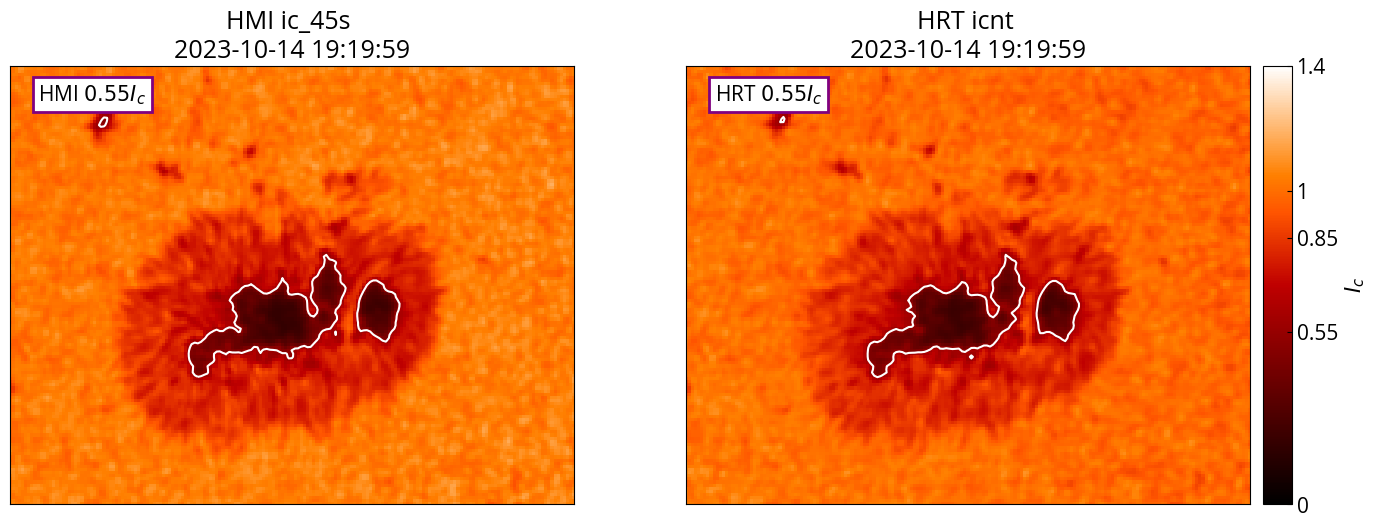

In [40]:
fig = plt.figure(figsize=(16,8))

cmax=1.4
cmin=0

i=67

tmp = hmi_ic_arr[:,:,i]
fac = np.mean(tmp[~np.isnan(tmp)])

ax = plt.subplot(121)
ax.set_aspect('equal')
ax.imshow(tmp/fac, origin = "lower", cmap = "gist_heat", vmin = cmin, vmax = cmax)
ax.set_title(f"HMI ic_45s \n{times[i]}") 

plt.xlim(970,1150)
plt.ylim(2180,2320)

#contour of HRT FOV
x = range(tmp.shape[1])
y = range(tmp.shape[0])
xv, yv = np.meshgrid(x, y)
cs = plt.contour(xv, yv, tmp/fac, levels = [0.55],colors="white")
#plt.clabel(cs, inline=False)

#legend for contour
ylims = ax.get_ylim()
xlims = ax.get_xlim()
t = ax.text(0.05*(xlims[1]-xlims[0])+xlims[0],(0.92*(ylims[1]-ylims[0])+ylims[0])-0.1, s = r'HMI $0.55I_{c}$', fontsize=15)
t.set_bbox(dict(facecolor='white', alpha=1, edgecolor='purple', linewidth=2))

ax.xaxis.set_tick_params(labelbottom=False)
ax.yaxis.set_tick_params(labelleft=False)

# Hide X and Y axes tick marks
ax.set_xticks([])
ax.set_yticks([])

ax2 = plt.subplot(122)
ax2.set_aspect('equal')
hrt_data = hrt_ic_arr[:,:,i]
hrt_copy = ax2.imshow(hrt_data, origin = "lower", cmap = "gist_heat", vmin = cmin, vmax = cmax)
ax2.set_title(f'HRT icnt \n{times[i]}')

plt.xlim(970,1150)
plt.ylim(2180,2320)

#contour of HRT FOV
x = range(hrt_data.shape[1])
y = range(hrt_data.shape[0])
xv, yv = np.meshgrid(x, y)
cs = plt.contour(xv, yv, hrt_data, levels = [0.55],colors="white")
#plt.clabel(cs, inline=False)

#legend for contour
ylims = ax2.get_ylim()
xlims = ax2.get_xlim()
t = ax2.text(0.05*(xlims[1]-xlims[0])+xlims[0],(0.92*(ylims[1]-ylims[0])+ylims[0])-0.1, s = 'HRT $0.55I_{c}$', fontsize=15)
t.set_bbox(dict(facecolor='white', alpha=1, edgecolor='purple', linewidth=2))

ax2.xaxis.set_tick_params(labelbottom=False)
ax2.yaxis.set_tick_params(labelleft=False)

# Hide X and Y axes tick marks
ax2.set_xticks([])
ax2.set_yticks([])

axins4 = inset_axes(ax2,width="5%",height="100%",loc='center right',borderpad=-2)
cbar = fig.colorbar(hrt_copy, cax=axins4, orientation="vertical", ticks=[0,0.55,0.85,1,1.4])
cbar.ax.yaxis.set_ticks_position('right')
cbar.set_label(r"$I_{c}$")
cbar.ax.set_yticklabels(['0','0.55','0.85','1','1.4'])

#plt.savefig('../plots/original_blos_hrt_hmi_m45s_zoom.png',bbox_inches='tight', dpi=300)
plt.show()

In [42]:
len(times)

128

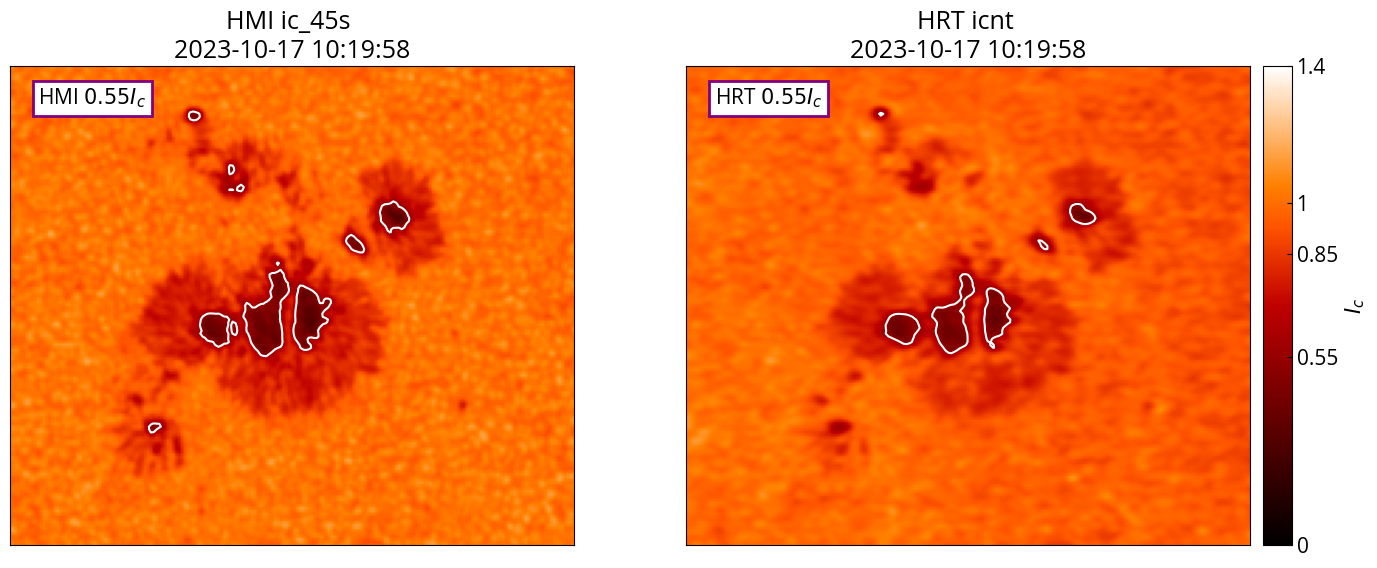

In [48]:
fig = plt.figure(figsize=(16,8))

cmax=1.4
cmin=0

i=127

tmp = hmi_ic_arr[:,:,i]
fac = np.mean(tmp[~np.isnan(tmp)])

ax = plt.subplot(121)
ax.set_aspect('equal')
ax.imshow(tmp/fac, origin = "lower", cmap = "gist_heat", vmin = cmin, vmax = cmax)
ax.set_title(f"HMI ic_45s \n{times[i]}") 

plt.xlim(2050,2250)
plt.ylim(2150,2320)

#contour of HRT FOV
x = range(tmp.shape[1])
y = range(tmp.shape[0])
xv, yv = np.meshgrid(x, y)
cs = plt.contour(xv, yv, tmp/fac, levels = [0.55],colors="white")
#plt.clabel(cs, inline=False)

#legend for contour
ylims = ax.get_ylim()
xlims = ax.get_xlim()
t = ax.text(0.05*(xlims[1]-xlims[0])+xlims[0],(0.92*(ylims[1]-ylims[0])+ylims[0])-0.1, s = r'HMI $0.55I_{c}$', fontsize=15)
t.set_bbox(dict(facecolor='white', alpha=1, edgecolor='purple', linewidth=2))

ax.xaxis.set_tick_params(labelbottom=False)
ax.yaxis.set_tick_params(labelleft=False)

# Hide X and Y axes tick marks
ax.set_xticks([])
ax.set_yticks([])

ax2 = plt.subplot(122)
ax2.set_aspect('equal')
hrt_data = hrt_ic_arr[:,:,i]
hrt_copy = ax2.imshow(hrt_data, origin = "lower", cmap = "gist_heat", vmin = cmin, vmax = cmax)
ax2.set_title(f'HRT icnt \n{times[i]}')

plt.xlim(2050,2250)
plt.ylim(2150,2320)

#contour of HRT FOV
x = range(hrt_data.shape[1])
y = range(hrt_data.shape[0])
xv, yv = np.meshgrid(x, y)
cs = plt.contour(xv, yv, hrt_data, levels = [0.55],colors="white")
#plt.clabel(cs, inline=False)

#legend for contour
ylims = ax2.get_ylim()
xlims = ax2.get_xlim()
t = ax2.text(0.05*(xlims[1]-xlims[0])+xlims[0],(0.92*(ylims[1]-ylims[0])+ylims[0])-0.1, s = 'HRT $0.55I_{c}$', fontsize=15)
t.set_bbox(dict(facecolor='white', alpha=1, edgecolor='purple', linewidth=2))

ax2.xaxis.set_tick_params(labelbottom=False)
ax2.yaxis.set_tick_params(labelleft=False)

# Hide X and Y axes tick marks
ax2.set_xticks([])
ax2.set_yticks([])

axins4 = inset_axes(ax2,width="5%",height="100%",loc='center right',borderpad=-2)
cbar = fig.colorbar(hrt_copy, cax=axins4, orientation="vertical", ticks=[0,0.55,0.85,1,1.4])
cbar.ax.yaxis.set_ticks_position('right')
cbar.set_label(r"$I_{c}$")
cbar.ax.set_yticklabels(['0','0.55','0.85','1','1.4'])

#plt.savefig('../plots/original_blos_hrt_hmi_m45s_zoom.png',bbox_inches='tight', dpi=300)
plt.show()